## Introduction
----
In this assignment, you will convert your batch least squares solution to a recursive one! Recall that you have the following data:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

This time, you will be fitting a linear model which includes an offset, $y = Rx + b$. If Ohm's law ($V = RI$) holds, we expect this offset to be near zero.

You will set the initial parameters with the assumption that your prior estimate of the resistance $R = 4$ is not very good. Also, since you are fairly certain that Ohm's law ($V = RI$) does, in fact, hold, it is safe to assume with high confidence that the offset term $b$ will be close to zero. Initialize the estimator as follows:

$$\hat{R} \sim \mathcal{N}(4, 10.0), \hat{b} \sim \mathcal{N}(0, 0.2)$$

You can assume that we know the current perfectly, and that the voltage measurements are corrupted by additive, independent and identitically distributed Gaussian noise with variance $0.0225 ~ V^2$.

## Getting Started
----
As before, load the current and voltge measurements into numpy arrays and plot the values:

In [ ]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

I = np.array([0.2, 0.3, 0.4, 0.5, 0.6])
V = np.array([1.23, 1.38, 2.06, 2.47, 3.17])

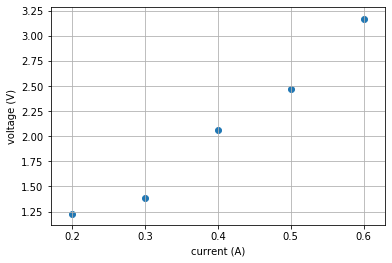

In [2]:
plt.scatter(I, V)

plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)
plt.show()

## Batch Least Squares Method
----
### Batch Estimator
The batch least squares method will be fitting a model which contains an offset $y = Rx + b$. We can use this result later for comparison.

The parameters of the line fit - ([Slope (R), Offset(b)]
[4.97  0.074]


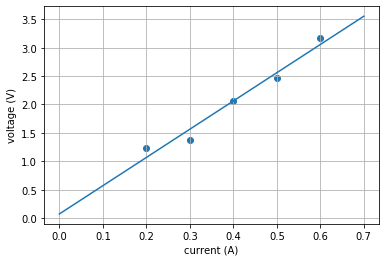

In [32]:
H = np.ones((5,2))
H[:, 0]= I
R_est = inv(H.T.dot(H)).dot(H.T.dot(V))
print('The parameters of the line fit - ([Slope (R), Offset(b)]')
print(R_est)

I_line = np.arange(0, 0.8, 0.1)
V_line = R_est[0]*I_line + R_est[1]
plt.scatter(I, V)
plt.plot(I_line, V_line)
plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)
plt.show()

As expected, the offset parameter $\hat{b}$ is near zero, while $\hat{R}$ closely approximates the true resistance value of $R = 5~\Omega$.

### Recursive Estimator

**Initialize the Parameter and Covariance Estimates**:

----

* Initialize Parameter Estimate $$\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right]$$ 
* Initialize the Covariance Estimate $$\mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]$$
* Initialize the Measurement Variance $$\mathbf{R}_k = \left[\mathbf{R} = 0.0225\right]$$

In [37]:
# Initialize the parameter estimate X_0
# Here we know that the parameter we are esimating is Voltage
# Which can be written as V_line = V_est_k[1]*I_line + V_est_k[0]
# Here this Matrix describs the initial guess of slope = 4 and offset = 0
# We get this from the batch solution

V_est_k = np.array([4, 0])


# Initialize the 2x2 covaraince matrix
P_k = np.array([[10 , 0],
                [0 , 0.2]])

#Measurement Variance
# Since each measurement has the same variance the martix R_k = R = Constant
R = 0.0225

**Pre-allocate our solutions as to save the estimate at Every Step**:

Here we are storing our solutions for every step

In [54]:
#The number of measurements from our table we can see are = 5
# Shape[0] returns the coloumns of the Current (T) Matrix
No_of_Measur = I.shape[0]

# Here we know that the V_estimate will be returning 2 values (Slope and Offset)
# We create 6 NULL Matrices of size (1 Row and 2 Coloumns), where each row will be filled with 2 values for every update
V_hist = np.zeros((No_of_Measur + 1,2))

# Here we know that the P_k will be returning 4 values represented by a 2x2 matrix
# We create 6 NULL Matrices of size (2x2), where each matrix will be filled with 4 values for every update
P_hist = np.zeros((No_of_Measur + 1,2,2))

# Now we are storing the first estimate and this will be iterated as k increases
V_hist[0] = V_est_k
P_hist[0] = P_k

**For Every Measurement k**:

----
  * Update the Measurement Matrix $$\mathbf{H}_k = \left(\mathbf{I[k],1}\right)$$
  * The Correction Gain $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Update the Parameter Estimate $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Update the Covariance Estimate $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$
  

In [55]:
#Iterate over the measurements

for k in range(No_of_Measur):
    #Construct H_k
    # H_k is the measurement matrix and has value = 1 for all the measurements made
    # as there is no factor being multiplied when we measure
    # V_measured = H_k * V_actual + Variance ----> Here H_k = 1
    # But the first coloumn of H_k is the Initial current value and the second coloumn is 1
    H_k = np.array([[I[k], 1]]) # Why are we requiring 2 brackets ?
   
    #Construct K_k
    K_k = P_k @ H_k.T @ inv(H_k @ P_k @ H_k.T + R)
                    
    #Update our estimate
    # We are estimating the voltgage X_k = V_est_k
    V_est_k = V_est_k + K_k @ (V[k] - H_k @ V_est_k)
 
    #Update our uncertainty
    Iden_Matrix = np.eye(2)
    P_k = (Iden_Matrix - K_k @ H_k) @ P_k

    #Keep track of our history
    P_hist[k+1] = P_k
    V_hist[k+1] = V_est_k
    
print('The parameters of the line fit are ([Slope (R), Offset(b)]):')
print(V_est_k)

The parameters of the line fit are ([Slope (R), Offset(b)]):
[4.97504638 0.07118067]


## Plotting the Results
----
Let's plot out the solutions at every step. Does the value converge towards the batch least squares solution from the previous assignment?

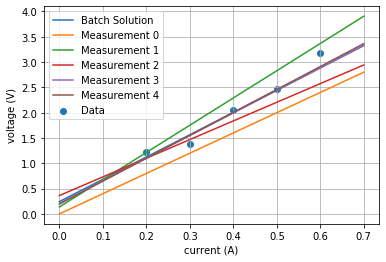

In [40]:
#Plot
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1)
for k in range(No_of_Measur):
    V_line = V_hist[k,0]*I_line + V_hist[k,1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))

plt.legend()
plt.show()

The resistance estimate does approach the true resistance value of $R = 5~\Omega$. Try modifying the initialization values (e.g., the intial uncertainty) - can you get a better final estimate?